In [1]:
%load_ext line_profiler
%load_ext memory_profiler

%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2

In [2]:
import util
import models

from os.path import expanduser
from os import path
import logging

logging.basicConfig(level=logging.INFO)

import matplotlib.pyplot as plt
import seaborn as sns

import yass
from yass import read_config, preprocess
from yass.augment import make_training_data, make
from yass.neuralnetwork import NeuralNetDetector, NeuralNetTriage, AutoEncoder 
from yass.explore import RecordingExplorer, SpikeTrainExplorer

import numpy as np
from scipy.io import loadmat

In [3]:
yass.set_config("../config/49-lab.yaml")
CONFIG = read_config()

DEBUG:yass.config.config:Loaded from file: ../config/49-lab.yaml
DEBUG:yass:CONFIG set to: {'data': {'root_folder': '/home/Edu/data', 'recordings': 'ej49_data1_set1.bin', 'geometry': 'ej49_geometry1.txt'}, 'resources': {'max_memory': '10MB', 'max_memory_gpu': '1GB', 'processes': 'max'}, 'recordings': {'dtype': 'int16', 'sampling_rate': 20000, 'n_channels': 49, 'spatial_radius': 70, 'spike_size_ms': 1, 'order': 'samples'}, 'preprocess': {'apply_filter': True, 'dtype': 'float32', 'if_file_exists': 'skip', 'filter': {'order': 3, 'low_pass_freq': 300, 'high_factor': 0.1}}, 'detect': {'method': 'threshold', 'temporal_features': 3, 'save_results': False, 'if_file_exists': 'skip', 'neural_network_detector': {'filename': '/home/Edu/dev/yass/src/yass/assets/models/detect_nn1.ckpt', 'threshold_spike': 0.5}, 'neural_network_triage': {'filename': '/home/Edu/dev/yass/src/yass/assets/models/triage_nn1.ckpt', 'threshold_collision': 0.5}, 'neural_network_autoencoder': {'filename': '/home/Edu/dev/yass/

In [4]:
path_to_data = path.expanduser('~/data')
path_to_ground_truth = path.join(path_to_data,
                                 'groundtruth_ej49_data1_set1.mat')
path_to_standarized = path.join(path_to_data, 'tmp', 'preprocess',
                               'standarized.bin')
path_to_geom = path.join(path_to_data, 'ej49_geometry1.txt')

In [5]:
# load ground truth
_ = loadmat(path_to_ground_truth)
gt = np.hstack([_['spt_gt'], _['L_gt']])

gt = gt[2:-1]
gt[:, 1] = gt[:, 1] - 1

In [6]:
re = RecordingExplorer(path_to_standarized, spike_size=15)
se = SpikeTrainExplorer(gt, re)

DEBUG:yass.explore.explorers:Loaded 49 waveforms
DEBUG:yass.explore.explorers:Finished computing templates, shape is: (31, 49, 49)


## Inspecting ground truth amplitudes and templates

In [7]:
def spike_amplitudes_from_spikes(spikes):
    return np.max(np.abs(spikes), axis=(0, 1))

In [8]:
amps = spike_amplitudes_from_spikes(se.templates)

/home/Edu/miniconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
DEBUG:matplotlib.font_manager:findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to DejaVu Sans ('/home/Edu/miniconda3/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000


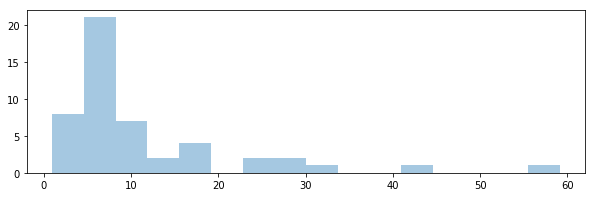

In [9]:
plt.rcParams['figure.figsize'] = (10, 3)
_ = sns.distplot(amps, kde=False)

DEBUG:matplotlib.font_manager:findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0 to DejaVu Sans ('/home/Edu/miniconda3/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000


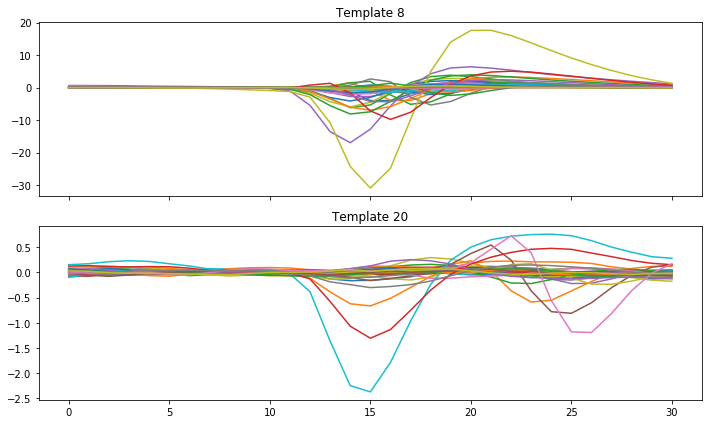

In [10]:
plt.rcParams['figure.figsize'] = (10, 6)
se.plot_templates(group_ids=[8, 20])

## Generating training data

In [11]:
min_amplitude = 5
n_spikes = 50000
n_templates = np.max(gt[:,1]) + 1
chosen_templates = np.arange(n_templates)

In [12]:
(x_detect, y_detect,
 x_triage, y_triage,
 x_ae, y_ae) = make_training_data(CONFIG, gt, chosen_templates,
                                  min_amplitude, n_spikes,
                                  data_folder='/home/Edu/data/nnet/')

INFO:yass.augment.make:Getting templates...
INFO:yass.templates.util:Computing templates...
DEBUG:yass.batch.generator:Max memory: 10 MB. Itemsize: 4 bytes
INFO:yass.batch.batch:Applying function yass.templates.util.compute_weighted_templates...
  0%|          | 0/113 [00:00<?, ?it/s]DEBUG:yass.batch.generator:Observations per channel: 6,000,000. Number of channels: 49. Total observations: 294,000,000 Size to traverse: 1.1 GB
DEBUG:yass.batch.generator:Max observations per batch: 2,621,402 (10 MB), 53,498 max observations per channel
DEBUG:yass.batch.generator:Number of batches: 113
DEBUG:yass.batch.generator:Last batch with 402,976 observations (1611904), 8,224 observations per channel
DEBUG:yass.batch.util:Processing batch 0...
DEBUG:yass.batch.util:Applying function in batch 0...
DEBUG:yass.batch.util:Done Applying function in batch 0...
DEBUG:yass.batch.util:Processing batch 1...
DEBUG:yass.batch.util:Applying function in batch 1...
DEBUG:yass.batch.util:Done Applying function in b

DEBUG:yass.batch.util:Processing batch 43...
DEBUG:yass.batch.util:Applying function in batch 43...
DEBUG:yass.batch.util:Done Applying function in batch 43...
DEBUG:yass.batch.util:Processing batch 44...
DEBUG:yass.batch.util:Applying function in batch 44...
DEBUG:yass.batch.util:Done Applying function in batch 44...
 40%|███▉      | 45/113 [00:01<00:02, 26.83it/s]DEBUG:yass.batch.util:Processing batch 45...
DEBUG:yass.batch.util:Applying function in batch 45...
DEBUG:yass.batch.util:Done Applying function in batch 45...
DEBUG:yass.batch.util:Processing batch 46...
DEBUG:yass.batch.util:Applying function in batch 46...
DEBUG:yass.batch.util:Done Applying function in batch 46...
DEBUG:yass.batch.util:Processing batch 47...
DEBUG:yass.batch.util:Applying function in batch 47...
DEBUG:yass.batch.util:Done Applying function in batch 47...
 42%|████▏     | 48/113 [00:01<00:02, 26.92it/s]DEBUG:yass.batch.util:Processing batch 48...
DEBUG:yass.batch.util:Applying function in batch 48...
DEBU

DEBUG:yass.batch.util:Processing batch 90...
DEBUG:yass.batch.util:Applying function in batch 90...
DEBUG:yass.batch.util:Done Applying function in batch 90...
DEBUG:yass.batch.util:Processing batch 91...
DEBUG:yass.batch.util:Applying function in batch 91...
DEBUG:yass.batch.util:Done Applying function in batch 91...
 81%|████████▏ | 92/113 [00:03<00:00, 27.91it/s]DEBUG:yass.batch.util:Processing batch 92...
DEBUG:yass.batch.util:Applying function in batch 92...
DEBUG:yass.batch.util:Done Applying function in batch 92...
DEBUG:yass.batch.util:Processing batch 93...
DEBUG:yass.batch.util:Applying function in batch 93...
DEBUG:yass.batch.util:Done Applying function in batch 93...
DEBUG:yass.batch.util:Processing batch 94...
DEBUG:yass.batch.util:Applying function in batch 94...
DEBUG:yass.batch.util:Done Applying function in batch 94...
 84%|████████▍ | 95/113 [00:03<00:00, 27.93it/s]DEBUG:yass.batch.util:Processing batch 95...
DEBUG:yass.batch.util:Applying function in batch 95...
DEBU

In [13]:
print(x_detect.shape, x_triage.shape, x_ae.shape)

(650052, 21, 7) (150012, 21, 7) (747282, 21)


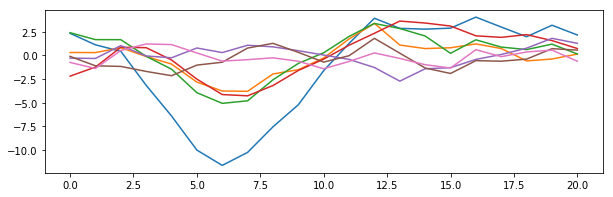

In [14]:
plt.rcParams['figure.figsize'] = (10, 3)
_ = plt.plot(x_detect[200])

In [15]:
x_detect_positive = x_detect[y_detect == 1]
x_detect_negative = x_detect[y_detect == 0]

In [16]:
amps_positive = np.max(np.abs(x_detect_positive), axis=(1, 2))
amps_negative = np.max(np.abs(x_detect_negative), axis=(1, 2))

/home/Edu/miniconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


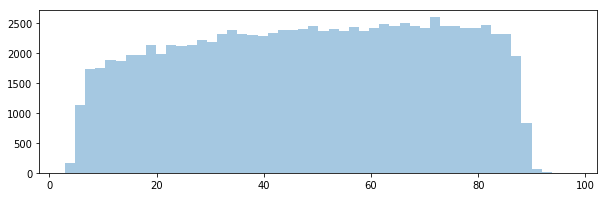

In [17]:
plt.rcParams['figure.figsize'] = (10, 3)
_ = sns.distplot(amps_positive, kde=False)

/home/Edu/miniconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


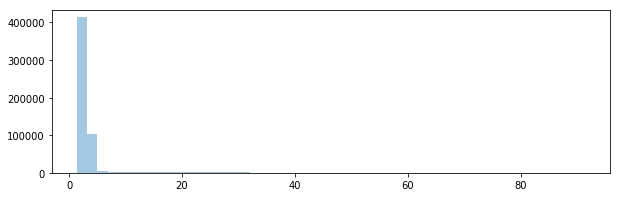

In [18]:
plt.rcParams['figure.figsize'] = (10, 3)
_ = sns.distplot(amps_negative, kde=False)

# Training

In [19]:
n_iter = 5000

detect_name = path.join('models', 'detect-'+util.directory()+'.ckpt')
triage_name = path.join('models', 'triage-'+util.directory()+'.ckpt')

## Detector training

In [20]:
filters_detect = [8, 4]

_, waveform_length, n_neighbors =  x_detect.shape

detector = NeuralNetDetector(detect_name, filters_detect,
                             waveform_length, n_neighbors,
                             threshold=0.5,
                             channel_index=CONFIG.channel_index,
                             n_iter=n_iter)

detector.fit(x_detect, y_detect)

DEBUG:yass.neuralnetwork.model_detector:Training detector network...
12487503it [01:25, 291278.94it/s]                   DEBUG:yass.neuralnetwork.model_detector:Saving network: models/detect-27-Jun-2018@19-25-17.ckpt
DEBUG:yass.neuralnetwork.model_detector:Approximate training true positive rate: 1.0, false positive rate: 0.0
12502500it [01:25, 145813.43it/s]
DEBUG:yass.neuralnetwork.model_detector:Saving network parameters: models/detect-27-Jun-2018@19-25-17.yaml


## Triage training

In [30]:
filters_triage = [8, 4]
_, waveform_length, n_neighbors = x_triage.shape

triage = NeuralNetTriage(triage_name, filters_triage,
                         waveform_length=waveform_length,
                         threshold=0.5,
                         n_neighbors=n_neighbors,
                         n_iter=n_iter)

triage.fit(x_triage, y_triage)

DEBUG:yass.neuralnetwork.model_triage:Training triage network...
12482506it [00:31, 778173.18it/s]                  DEBUG:yass.neuralnetwork.model_triage:Saving network: models/triage-27-Jun-2018@19-25-17.ckpt
DEBUG:yass.neuralnetwork.model_triage:Approximate training true positive rate: 0.9263803680981595, false positive rate: 0.13753581661891118
12502500it [00:31, 394992.56it/s]
DEBUG:yass.neuralnetwork.model_triage:Saving network parameters: models/triage-27-Jun-2018@19-25-17.yaml


# Predict

In [21]:
output_dir = 'tmp/'

(path_to_standarized,
 standarized_params,
 whiten_filter) = preprocess.run(output_directory=output_dir,
                                 if_file_exists='skip')

INFO:yass.preprocess.run:Output dtype for transformed data will be float32


In [22]:
explorer_std = RecordingExplorer(path_to_standarized,
                                 path_to_geom=None,
                                 spike_size=15, neighbor_radius=70)

In [23]:
_data = explorer_std.reader.data
window_size = 350000
idx = gt[105963, 0]
data = _data[idx-window_size:idx+window_size, :]

## Detect predict

In [24]:
output_names = ('spike_index', 'waveform', 'probability')

(spike_index, waveform,
 proba) = detector.predict(data, output_names=output_names)

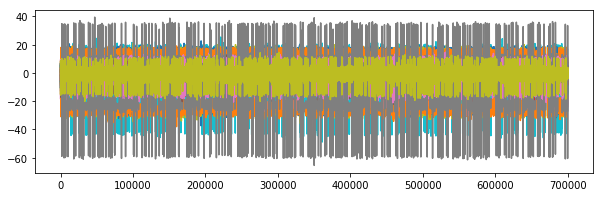

In [25]:
_ = plt.plot(data)

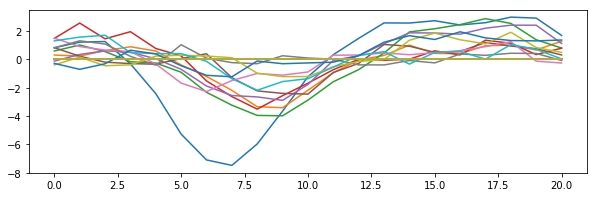

In [26]:
_ = plt.plot(waveform[0, :])

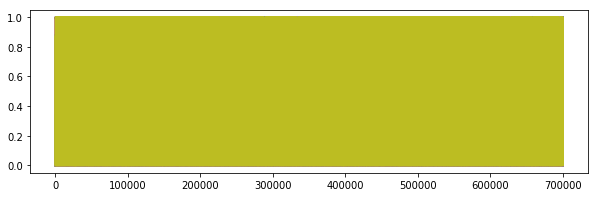

In [29]:
_ = plt.plot(proba)

## Triage predict

In [34]:
idx_clean = triage.predict(waveform[:, :, :x_triage.shape[2]])

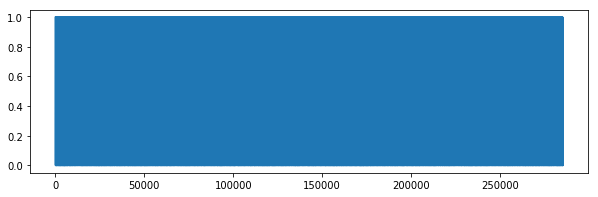

In [37]:
_ = plt.plot(idx_clean)